In [1]:
'''
All Credits to John " https://zindi.africa/users/Johnowhitaker ", for his amazing starting kernel, and live video
to help us all.
'''

'\nAll Credits to John " https://zindi.africa/users/Johnowhitaker ", for his amazing starting kernel, and live video\nto help us all.\n'

In [2]:
## Run once to install:
# !pip install geopandas rasterio
# !pip install descartes
# !pip install fastai2
# !pip install tqdm
# !pip install efficientnet_pytorch

In [3]:
## For reproducible results.
## Results may still not be reproducible if different hardware config is used, or the package versions are changed
def random_seed(seed_value):
    import random 
    random.seed(seed_value) # Python
    import numpy as np
    np.random.seed(seed_value) # cpu vars
    import torch
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [4]:
import pandas as pd
import numpy as np
import random
import geopandas as gpd
import rasterio
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

import gc

from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm_notebook
import fastai2
from fastai2.vision.all import *

In [5]:
import fastai2.vision as fvs

In [6]:
from efficientnet_pytorch import EfficientNet

In [7]:
fvs.models.densenet169

<function torchvision.models.densenet.densenet169(pretrained=False, progress=True, **kwargs)>

In [8]:
df = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
df.sample(5)

,ID,LAT,LON,Label
4194,Z6FT904,-25.688,28.383,False
3802,VOX93GO,-25.718,28.397,False
2022,H6RPSIV,-25.701,28.369,False
3722,V03ERJZ,-25.766,28.408,False
3659,UDH286F,-25.697,28.416,True


In [9]:
df['Label'].value_counts(normalize=True)

False    0.744452
True     0.255548
Name: Label, dtype: float64

In [10]:
df.shape

(4281, 4)

In [11]:
df.columns

Index(['ID', 'LAT', 'LON', 'Label'], dtype='object')

In [12]:
hard_df = pd.read_csv('diff_data.csv')
hard_df

,ID,LAT,LON,Label
0,0,-25.575270,28.044163,0
1,1,-25.976990,28.208228,1
2,2,-25.559496,28.031268,1
3,3,-25.588444,28.035736,1
4,4,-25.746802,28.427842,1
...,...,...,...,...
4631,4631,-25.784792,28.055100,0
4632,4632,-25.722323,28.430543,1
4633,4633,-25.571966,28.036522,0
4634,4634,-25.924211,28.255441,0


In [13]:
# Check the extent
df.min(), df.max()

(ID       0059CI9
 LAT       -25.78
 LON        28.35
 Label      False
 dtype: object,
 ID       ZZ6LRO7
 LAT       -25.68
 LON        28.45
 Label       True
 dtype: object)

In [14]:
hard_df = hard_df[((df['LAT'] > -25.8) & (hard_df['LAT'] < -25.6)) & ((hard_df['LON'] > 28.3) & (hard_df['LON'] < 28.45))]
hard_df['Label'].value_counts(normalize=True)

0    0.751746
1    0.248254
Name: Label, dtype: float64

In [15]:
hard_df['Label'].value_counts()

0    1184
1     391
Name: Label, dtype: int64

In [16]:
# plt.figure(figsize=(12, 12))
# new_gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.LON, df.LAT))
# new_gdf.sample(frac = 1, random_state=2).plot(column = 'Label', categorical=True, legend=True, figsize=(12, 12))

In [17]:
df = pd.concat([df, hard_df[hard_df['Label'] == 1]], axis=0).reset_index(drop=True).sample(frac=1, random_state=2).reset_index(drop=True)

In [18]:
df['Label'].value_counts(normalize=True)

0    0.682149
1    0.317851
Name: Label, dtype: float64

In [19]:
# plt.figure(figsize=(12, 12))
# new_gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.LON, df.LAT))
# new_gdf.sample(frac = 1, random_state=2).plot(column = 'Label', categorical=True, legend=True, figsize=(12, 12))

In [20]:
# CHeck shape and number of True labels
df.shape, df.Label.sum()

((4672, 4), 1485)

In [21]:
df.columns

Index(['ID', 'LAT', 'LON', 'Label'], dtype='object')

In [22]:
# Check the extent
df.min(), df.max()

(LAT     -25.78
 LON      28.35
 Label     0.00
 dtype: float64,
 LAT     -25.68
 LON      28.45
 Label     1.00
 dtype: float64)

In [23]:
# Sample submission:
ss = pd.read_csv('SampleSubmission.csv')
ss.head(3)

,ID,Label
0,00MZGKU,0
1,015JA41,0
2,01POB64,0


In [24]:
 dataset = rasterio.open('2528C.tif') # We'll use rasterio for all raster operations

In [25]:
dataset.bounds # Check the geographoc bounds of this tile - notice that it covers all the training data.

BoundingBox(left=27.9999999999999, bottom=-25.999999999894882, right=28.4999999999999, top=-25.499999999894882)

In [26]:
# We can get information such as the number of bands and the band names. 
# In this case there are 3, for R, G and B channels
band_names = dataset.descriptions
n_bands = dataset.count
band_names, n_bands

((None, None, None), 3)

In [27]:
# # Load bands into RAM
red, green, blue = dataset.read(1), dataset.read(2), dataset.read(3)

In [28]:
W, H = 250, 250

In [29]:
# Get the image:
random_seed(19)
def get_x(ID):
    row = df.loc[df.ID == ID]
    lat, lon = row['LAT'].values[0], row['LON'].values[0]
    im = np.zeros((W, H, 3), np.uint8)
    row, col = dataset.index(lon, lat)
    for i, band in enumerate([red, green, blue]):
        im[:,:,i] = band[row-W//2: row+W//2, col-H//2:col+H//2]
    
    return im

# And the label
def get_y(ID):
    row = df.loc[df.ID == ID]
    return int(row['Label'].values[0])

# Get the list of Image IDS:
def get_im_ids(path):
    return df.ID.values

# And build the datablock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_im_ids,
    get_x=get_x,
    get_y=get_y, 
    splitter=RandomSplitter(valid_pct=0.02),
    batch_tfms=aug_transforms(size=W, do_flip=True, flip_vert=True, max_rotate=180, max_lighting=0.6, p_lighting=0.12)
)
dls = dblock.dataloaders(Path(''), bs=32)
# dls.show_batch()

In [31]:
# Create the learner
random_seed(1)
learn = cnn_learner(dls, densenet201, metrics=[accuracy])
# learn = Learner(dls, getModel(), metrics=[accuracy])
# Train
learn.fine_tune(13)

epoch,train_loss,valid_loss,accuracy,time
0,0.431771,0.313504,0.913979,02:51


epoch,train_loss,valid_loss,accuracy,time
0,0.236059,0.208097,0.924731,03:53
1,0.210748,0.203281,0.924731,03:53
2,0.187891,0.153527,0.935484,03:53
3,0.173008,0.150396,0.946237,03:53
4,0.129541,0.165049,0.946237,03:53
5,0.129665,0.127655,0.956989,03:53
6,0.104543,0.101025,0.946237,03:53
7,0.089811,0.154113,0.956989,03:54
8,0.066553,0.107336,0.956989,03:53
9,0.068954,0.086094,0.967742,03:53


In [32]:
!ls *.tif

2528C.tif  2628C.tif  2930C.tif  2930D.tif


In [33]:
dataset = rasterio.open('2930D.tif')
red, green, blue = dataset.read(1), dataset.read(2), dataset.read(3)

In [34]:
test['Label'] = 0
df = test.copy()

In [35]:
random_seed(22)
idxs = test['ID'].values
tdl = learn.dls.test_dl(idxs, )
test_preds, test_labels = learn.tta(dl=tdl, n=11, beta=1, use_max=True)

In [36]:
# test_preds, test_labels = learn.tta(ds_idx = df[:-test.shape[0]].index.tolist())

In [37]:
pd.Series(test_preds.numpy()[:, 1]).sort_values(ascending=False)[:20]

2281    0.997591
1028    0.996383
1854    0.993426
790     0.991529
697     0.988099
1916    0.987260
1726    0.979412
938     0.975142
2450    0.973273
417     0.972466
988     0.971947
2473    0.971708
1235    0.970712
1632    0.970707
859     0.970353
1570    0.967057
1441    0.965581
1106    0.964939
1404    0.963160
1431    0.959768
dtype: float32

In [38]:
pd.Series(test_preds.numpy()[:, 1]).round().value_counts(normalize=True)

0.0    0.873708
1.0    0.126292
dtype: float64

In [39]:
test['Label'] = [p[1] for p in test_preds.numpy()]
test.head()

,ID,LAT,LON,Label
0,00MZGKU,-29.8920,30.8575,0.008425
1,015JA41,-29.8905,30.8705,0.043786
2,01POB64,-29.9615,30.8950,0.105503
3,02125F8,-29.9660,30.8500,0.004320
4,03E8VFF,-29.9080,30.8760,0.000715


In [40]:
test['Label'].describe()

count    2613.000000
mean        0.158533
std         0.255482
min         0.000004
25%         0.003059
50%         0.026683
75%         0.190568
max         0.997591
Name: Label, dtype: float64

In [41]:
test['Label'] = np.clip(test['Label'], 0, 0.8)

In [42]:
test['Label'].round().value_counts(normalize=True)

0.0    0.873708
1.0    0.126292
Name: Label, dtype: float64

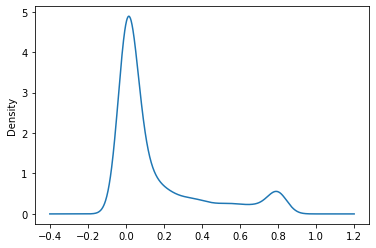

In [43]:
test['Label'].plot(kind='density')

In [44]:
# test[['ID', 'Label']].to_csv('outputs/sub_0.616.csv', index=False)
test[['ID', 'Label']].to_csv('sub_41.csv', index=False)

In [45]:
test.head()

,ID,LAT,LON,Label
0,00MZGKU,-29.8920,30.8575,0.008425
1,015JA41,-29.8905,30.8705,0.043786
2,01POB64,-29.9615,30.8950,0.105503
3,02125F8,-29.9660,30.8500,0.004320
4,03E8VFF,-29.9080,30.8760,0.000715
